In [2291]:
import pandas as pd
import numpy as np 
import math
from matplotlib import pyplot as plt, patches
import matplotlib as mpl
import seaborn as sns
from sklearn import linear_model
from collections import defaultdict
import torch
import torch.nn as nn 

In [2292]:
# Importing preprocessed dataset

df = pd.read_csv('data/dfFinal.csv')
df.timestamp = pd.to_datetime(df.timestamp)
df.head()

,timestamp,indoor_co2 [ppm],wifi_connected_devices [number],occupant_count [number],0,1,2,3,hour_sin,hour_cos
0,2021-09-07 08:50:00+08:00,480.066681,4,1,0.227173,0.953840,0.542007,0.041682,0.866025,-0.500000
1,2021-09-07 08:55:00+08:00,481.166656,6,2,0.227173,0.953840,0.542007,0.041682,0.866025,-0.500000
2,2021-09-07 09:00:00+08:00,477.533325,7,4,0.144319,0.858028,0.690382,0.075178,0.707107,-0.707107
3,2021-09-07 09:05:00+08:00,474.233337,6,4,0.144319,0.858028,0.690382,0.075178,0.707107,-0.707107
4,2021-09-07 09:10:00+08:00,477.866669,9,7,0.144319,0.858028,0.690382,0.075178,0.707107,-0.707107


In [2293]:
# Create an index for every hour value for one-hot encoding

hours = [t.hour for t in df.timestamp]
hoursIdx = dict(zip(list(set(hours))[:-1], range(len(set(hours))-1)))

In [2294]:
hoursIdx

{8: 0,
 9: 1,
 10: 2,
 11: 3,
 12: 4,
 13: 5,
 14: 6,
 15: 7,
 16: 8,
 17: 9,
 18: 10,
 19: 11,
 20: 12}

In [2295]:
# Calculate means and standard deviations to standardize attributes

indoorCO2Mean = np.mean(df['indoor_co2 [ppm]'])
indoorCO2Std = np.std(df['indoor_co2 [ppm]'])

wifiDevicesMean = np.mean(df['wifi_connected_devices [number]'])
wifiDevicesStd = np.std(df['wifi_connected_devices [number]'])

In [2296]:
X = []
y = []

def feat(row, hourEncoding):

    if hourEncoding == 'one-hot':
        # One-hot encode
        hourEncode = [0]*13 
        hour = row['timestamp'].hour
        if hour in hoursIdx.keys():
            hourEncode[hoursIdx[hour]] = 1
    elif hourEncoding == 'sin/cos':
        hourEncode = [row['hour_sin'], row['hour_cos']]
    else:
        hourEncode = [row['0'], row['1'], row['2'], row['3']]
    
    # Standardization
    indoorCO2, wifiDevices = row['indoor_co2 [ppm]'], row['wifi_connected_devices [number]']
    indoorCO2 = (indoorCO2-indoorCO2Mean) / indoorCO2Std
    wifiDevices = (wifiDevices-wifiDevicesMean) / wifiDevicesStd

    X.append([1]+hourEncode+[indoorCO2]+[wifiDevices])
    y.append(row['occupant_count [number]'])

    return None

def RMSE(actuals, preds):
    sqrdErrors = [(p[0]-p[1])**2 for p in zip(actuals, preds)]
    return np.sqrt(sum(sqrdErrors) / len(sqrdErrors))


In [2297]:
df.apply(feat, hourEncoding='one-hot', axis=1);

In [2298]:
# sanity check

len(X) == len(y)

True

In [2299]:
# variable to store all models' performance

lrPerformance = defaultdict(float)
lrTrainPerformance = defaultdict(float)

In [2300]:
# Train / test split

threshold = int(len(X)*0.75)

XTrain = X[:threshold]
XTest = X[threshold:]
yTrain = y[:threshold]
yTest = y[threshold:]

In [2301]:
# sanity check

print(len(XTrain) + len(XTest) == len(X))
print(len(yTrain) + len(yTest) == len(y))

True
True


#### <b>Linear Regression</b> - stand alone ex. with one-hot encoding (sin/cos and RBF transformations done in a loop)

In [2302]:
# Model initiation and fit

lrModel = linear_model.LinearRegression(fit_intercept=False)
lrModel.fit(XTrain, yTrain)

LinearRegression(fit_intercept=False)

In [2303]:
# Make predictions and get RMSE

preds = lrModel.predict(XTest)
lrRMSE = RMSE(yTest, preds)
lrRMSE

2.2334939506347933

In [2304]:
# Get model specs

lrModel.coef_

array([2.51017815, 0.14027575, 0.45693332, 1.37661187, 1.87173858,
       1.86087422, 2.44248679, 3.27343789, 3.4271599 , 3.40350706,
       2.29825606, 1.79139328, 1.14432045, 0.63069239, 0.62363237,
       0.99554744])

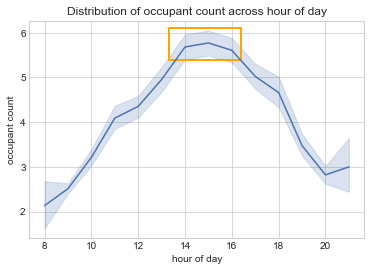

In [2305]:
mpl.style.use('seaborn-whitegrid')
sns.lineplot(x=hours, y=df['occupant_count [number]'])
plt.title('Distribution of occupant count across hour of day')
ax = plt.gca()
ax.add_patch(patches.Rectangle((13.3, 5.4), 3.1, 0.7, edgecolor='orange', \
    facecolor='none', linewidth=2))
plt.ylabel('occupant count')
plt.xlabel('hour of day')
plt.show();

[[1.        0.4428711]
 [0.4428711 1.       ]]


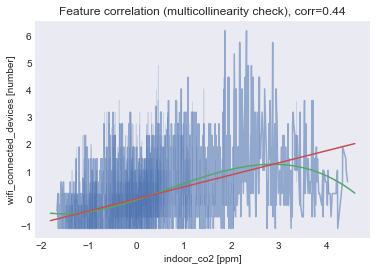

In [2306]:
# sanity check

arr1 = (df['indoor_co2 [ppm]']-indoorCO2Mean)/indoorCO2Std
arr2 = (df['wifi_connected_devices [number]']-wifiDevicesMean)/wifiDevicesStd

print(np.corrcoef(arr1, arr2))
line = np.linspace(-1.8, 4.6, 100)
mdl = np.poly1d(np.polyfit(arr1, arr2, 1))
mdl3 = np.poly1d(np.polyfit(arr1, arr2, 3))

# mpl.style.use('seaborn-dark-palette')
# mpl.style.use('seaborn-darkgrid')
# mpl.style.use('seaborn-deep')
mpl.style.use('seaborn-dark')

sns.lineplot(x=arr1, y=arr2, alpha=0.55)
plt.plot(line, mdl3(line))
plt.plot(line, mdl(line))

plt.title(f'Feature correlation (multicollinearity check), corr={np.round(mdl.coef[0], 2)}');

In [2307]:
lrPerformance[('lin-reg', 'one-hot')] = lrRMSE

In [2371]:
# Repeat for sin/cos and RBF hour transformations (Linear regression)

# Record prediction values for each model examine their distribution
model = []
predVal = []

for trans in ['one-hot', 'sin/cos', 'rbf']:
    X = []
    y = []
    df.apply(feat, hourEncoding=trans, axis=1)

    threshold = int(len(X)*0.75)
    XTrain = X[:threshold]
    XTest = X[threshold:]
    yTrain = y[:threshold]
    yTest = y[threshold:]
    featSample = X[0]

    # Model initiation and fit
    mdl = linear_model.LinearRegression(fit_intercept=False)
    mdl.fit(XTrain, yTrain)

    # Make predictions and get RMSE
    trainPreds = mdl.predict(XTrain)
    trainRMSE = RMSE(yTrain, trainPreds)
    testPreds = mdl.predict(XTest)
    testRMSE = RMSE(yTest, testPreds)

    lrPerformance[('lin-reg', trans)] = testRMSE
    lrTrainPerformance[('lin-reg', trans)] = trainRMSE
    model += [f'lin-reg, {trans}']*len(testPreds)
    predVal += list(testPreds)

    # Examine model
    print(f'Model - lin-reg, {trans}')
    print(f'Learning feature sample: {featSample}')
    # print(f'{featSample}')
    print(f'coefficients: {mdl.coef_}')
    # print(f'{mdl.coef_}')
    print('')


Model - lin-reg, one-hot
Learning feature sample: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.288331218068863, 0.20005668386070682]
coefficients: [2.51017815 0.14027575 0.45693332 1.37661187 1.87173858 1.86087422
 2.44248679 3.27343789 3.4271599  3.40350706 2.29825606 1.79139328
 1.14432045 0.63069239 0.62363237 0.99554744]

Model - lin-reg, sin/cos
Learning feature sample: [1, 0.8660254037844387, -0.4999999999999998, 0.288331218068863, 0.20005668386070682]
coefficients: [ 2.59559811 -1.90356412 -2.35367418  0.56816412  1.01537706]

Model - lin-reg, rbf
Learning feature sample: [1, 0.2271734201167346, 0.95384034078631, 0.5420069956565414, 0.041681672223569, 0.288331218068863, 0.20005668386070682]
coefficients: [-124.02729455   68.55032542   70.57850723   73.96893252   74.02193929
    0.6221681     0.9940373 ]



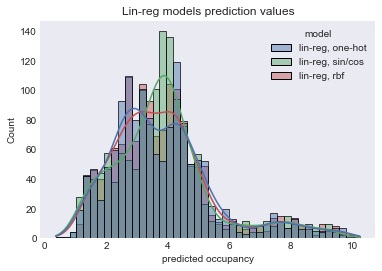

In [2372]:
# Plot distribution of prediction values

predVariety = pd.DataFrame(data={'model': model, 'predVal': predVal})
sns.histplot(data=predVariety, x='predVal', hue='model', kde=True, alpha=0.46);
plt.title('Lin-reg models prediction values')
plt.xlabel('predicted occupancy');

In [2373]:
lrPerformance

defaultdict(float,
            {('lin-reg', 'one-hot'): 2.2334939506347933,
             ('lin-reg', 'sin/cos'): 2.243164827500044,
             ('lin-reg', 'rbf'): 2.2266253252047497})

In [2374]:
lrTrainPerformance

defaultdict(float,
            {('lin-reg', 'one-hot'): 2.3504687786936733,
             ('lin-reg', 'sin/cos'): 2.3696494143564286,
             ('lin-reg', 'rbf'): 2.3559523957528716})

#### <b>Auto-regression</b>

In [2542]:
data = list(df['occupant_count [number]'])

In [2543]:
# Building the dataset, use T past values to predict the next value

T = 12
X = []
y = []
for t in range(len(data)-T):
    X.append(data[t:t+T])
    y.append(data[t+T])

X = np.array(X).reshape(-1, T)
y = np.array(y).reshape(-1, 1)
N = len(X)
print("X shape", X.shape, "Y shape", y.shape)

X shape (5747, 12) Y shape (5747, 1)


In [2544]:
X[0]

array([1, 2, 4, 4, 7, 4, 4, 2, 5, 3, 2, 2])

In [2545]:
y[0]

array([2])

In [2546]:
# Instantiate autoregression model

agModel = nn.Linear(T, 1)

In [2547]:
# Loss and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(agModel.parameters(), lr=0.01)

In [2548]:
# Make inputs and targets

threshold = int(len(X)*0.5)
XTrain = torch.from_numpy(X[:threshold].astype(np.float32))
yTrain = torch.from_numpy(y[:threshold].astype(np.float32))
XTest = torch.from_numpy(X[threshold:].astype(np.float32))
yTest = torch.from_numpy(y[threshold:].astype(np.float32))

In [2549]:
# sanity check

XTrain[:2]

tensor([[1., 2., 4., 4., 7., 4., 4., 2., 5., 3., 2., 2.],
        [2., 4., 4., 7., 4., 4., 2., 5., 3., 2., 2., 2.]])

In [2550]:
yTrain[:2]

tensor([[2.],
        [2.]])

In [2551]:
# Training

def gradient_descent(model,
                     criterion,
                     optimizer,
                     XTrain,
                     yTrain,
                     XTest,
                     yTest,
                    #  tol=0.001,
                     epochs=200):
    
    trainLosses, testLosses = np.zeros(epochs), np.zeros(epochs)
    
    lastLoss = None
    for ite in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(XTrain)
        loss = torch.sqrt(criterion(outputs, yTrain))

        # backward and optimize
        loss.backward()
        optimizer.step()

        # save loss
        trainLosses[ite] = loss.item()

        # Attempted a stop criterion using a tolerance but didn't seem to work 
        # (strange behavior in loss trend)
            # if lastLoss is None:
            #     lastLoss = loss.item()
            # elif lastLoss and abs(lastLoss-loss.item()) < tol:
            #     break

            # print(abs(lastLoss-loss.item()))


        # test loss
        testOutputs = model(XTest)
        testLoss = torch.sqrt(criterion(testOutputs, yTest))
        testLosses[ite] = testLoss.item()

        if (ite+1) % 5 == 0:
            print(f"Epoch {ite+1}/{epochs}, Train loss: {loss.item():.4f}, Test loss: {testLoss.item():.4f}")

        lastLoss = loss.item()
    
    return trainLosses, testLosses

In [2552]:
trainLosses, testLosses = gradient_descent(agModel,
                                           criterion,
                                           optimizer,
                                           XTrain,
                                           yTrain,
                                           XTest,
                                           yTest)

Epoch 5/200, Train loss: 1.5073, Test loss: 1.3148
Epoch 10/200, Train loss: 1.4714, Test loss: 1.0918
Epoch 15/200, Train loss: 1.4779, Test loss: 1.1614
Epoch 20/200, Train loss: 1.3478, Test loss: 1.0468
Epoch 25/200, Train loss: 1.3663, Test loss: 1.0465
Epoch 30/200, Train loss: 1.3124, Test loss: 1.0193
Epoch 35/200, Train loss: 1.2820, Test loss: 0.9828
Epoch 40/200, Train loss: 1.2672, Test loss: 0.9714
Epoch 45/200, Train loss: 1.2389, Test loss: 0.9507
Epoch 50/200, Train loss: 1.2159, Test loss: 0.9303
Epoch 55/200, Train loss: 1.1982, Test loss: 0.9143
Epoch 60/200, Train loss: 1.1801, Test loss: 0.8993
Epoch 65/200, Train loss: 1.1622, Test loss: 0.8856
Epoch 70/200, Train loss: 1.1458, Test loss: 0.8712
Epoch 75/200, Train loss: 1.1309, Test loss: 0.8590
Epoch 80/200, Train loss: 1.1170, Test loss: 0.8473
Epoch 85/200, Train loss: 1.1041, Test loss: 0.8366
Epoch 90/200, Train loss: 1.0922, Test loss: 0.8271
Epoch 95/200, Train loss: 1.0813, Test loss: 0.8179
Epoch 100/200

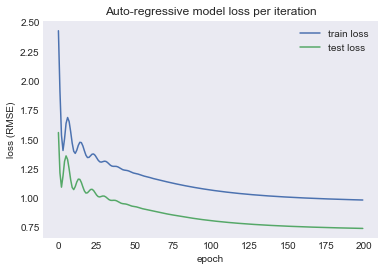

In [2553]:
# Plot loss per iteration

plt.plot(trainLosses, label='train loss')
plt.plot(testLosses, label='test loss')
plt.title('Auto-regressive model loss per iteration')
plt.xlabel('epoch')
plt.ylabel('loss (RMSE)')
plt.legend()
plt.show()

In [2554]:
# Make predictions and get RMSE

agPreds = []

# last train input
lastX = torch.from_numpy(np.array(XTrain[-1]).astype(np.float32))

while len(agPreds) < len(yTest):
    input_ = lastX.view(1, -1)
    pred = agModel(input_)

    agPreds.append(pred[0,0].item())

    # next input
    lastX = torch.cat((lastX[1:], pred[0]))

In [2555]:
y_test = np.array(yTest).reshape(1, -1)[0]
agRMSE = RMSE(y_test, agPreds)

In [2556]:
agRMSE

3.0081398487941824

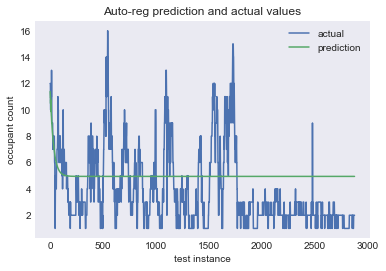

In [2557]:
# Plot actual and predicted values

plt.plot(y_test, label='actual')
plt.plot(agPreds, label='prediction')
plt.title('Auto-reg prediction and actual values')
plt.ylabel('occupant count')
plt.xlabel('test instance')
plt.legend();

In [2558]:
# Experiment with "wrong" forecast using true targets

preds_ = []
i = 0 # index of first test input
while len(preds_) < len(yTest):
    input_ = XTest[i].view(1, -1)
    pred_ = agModel(input_)[0,0].item()
    i += 1

    preds_.append(pred_)

In [2559]:
y_test = np.array(yTest).reshape(1, -1)[0]
RMSE(y_test, preds_)

0.7424532670448717

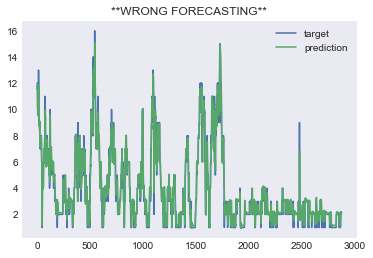

In [2560]:
plt.plot(y_test, label='target')
plt.plot(preds_, label='prediction')
plt.title('**WRONG FORECASTING**')
plt.legend();

In [2561]:
for name, param in agModel.named_parameters():
    print(name, param)

weight Parameter containing:
tensor([[-0.0574,  0.1160, -0.1021,  0.0780, -0.1016,  0.0548,  0.0229,  0.0122,
         -0.0338,  0.0866,  0.2538,  0.6284]], requires_grad=True)
bias Parameter containing:
tensor([0.2086], requires_grad=True)


In [2671]:
# Get auto-regression model params

for _ in agModel.named_parameters():
    print(_)

('weight', Parameter containing:
tensor([[-0.0574,  0.1160, -0.1021,  0.0780, -0.1016,  0.0548,  0.0229,  0.0122,
         -0.0338,  0.0866,  0.2538,  0.6284]], requires_grad=True))
('bias', Parameter containing:
tensor([0.2086], requires_grad=True))


In [2674]:
XTest[0]

tensor([ 9.,  8.,  9.,  8.,  8., 11., 11., 12., 11., 13., 11., 12.])

In [2743]:
# sanity check (match param weight with time for interpretation)

agWeights = None
agBias = None
for _ in agModel.named_parameters():
    if _[0] == 'weight':
        agWeights = _[1][0]
    else: 
        agBias = _[1][0]

firstTestPred = torch.sum(agWeights*XTest[0])+agBias

In [2744]:
firstTestPred

tensor(11.6002, grad_fn=<AddBackward0>)

In [2745]:
preds_[0]

11.60018539428711

#### <b>Recurrent neural network</b>

In [3440]:
# Set device GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3441]:
XTrain

tensor([[ 1.,  2.,  4.,  ...,  3.,  2.,  2.],
        [ 2.,  4.,  4.,  ...,  2.,  2.,  2.],
        [ 4.,  4.,  7.,  ...,  2.,  2.,  2.],
        ...,
        [ 9.,  9.,  9.,  ..., 11., 12., 11.],
        [ 9.,  9.,  9.,  ..., 12., 11., 13.],
        [ 9.,  9.,  8.,  ..., 11., 13., 11.]])

In [3442]:
# Build and reshape dataset

T = 12
X = []
y = []
for t in range(len(data)-T):
    X.append(data[t:t+T])
    y.append(data[t+T])

X = np.array(X).reshape(-1, T, 1)
y = np.array(y).reshape(-1, 1)
N = len(X)
print("X shape", X.shape, "Y shape", y.shape)

X shape (5747, 12, 1) Y shape (5747, 1)


In [3443]:
# Define simple RNN

class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnLayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden 
        self.K = n_outputs 
        self.L = n_rnnLayers 

        # Note: batch_first=True 
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity='relu',
            batch_first=True
        )

        # Dense layer
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # Initial hidden state 
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # Get RNN unit output
        # out is of size (N, T, M)
        # 2nd return val is hidden state at each hidden layer (no need now)
        # 1st return val is hidden state at each time instance
        out, _ = self.rnn(X, h0)

        # We only want h(t) at the final time step
        # N x M -> N x K
        out = self.fc(out[:, -1, :])

        return out
    
    def get_hidden(self, X):
        # Initial hidden state 
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, _ = self.rnn(X, h0)

        return out

In [3444]:
# Instantiate model

rnnModel = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnLayers=1, n_outputs=1)
rnnModel.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [3445]:
# Loss and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnnModel.parameters(), lr=0.1)

In [3446]:
# Make inputs and targets

threshold = int(len(X)*0.5)
X_train = torch.from_numpy(X[:threshold].astype(np.float32))
y_train = torch.from_numpy(y[:threshold].astype(np.float32))
X_test = torch.from_numpy(X[threshold:].astype(np.float32))
y_test = torch.from_numpy(y[threshold:].astype(np.float32))

In [3447]:
# Move data to device

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [3448]:
# sanity check

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([2873, 12, 1]),
 torch.Size([2873, 1]),
 torch.Size([2874, 12, 1]),
 torch.Size([2874, 1]))

In [3449]:
# Training

def rnnGradientDescent(model,
                       criterion,
                       optimizer,
                       X_train,
                       y_train,
                       X_test,
                       y_test,
                       epochs=200):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for ite in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        loss = torch.sqrt(criterion(outputs, y_train))

        # backward and optimize
        loss.backward()
        optimizer.step()

        # save loss
        train_losses[ite] = loss.item()

        # test loss
        test_outputs = model(X_test)
        test_loss = torch.sqrt(criterion(test_outputs, y_test))
        test_losses[ite] = test_loss.item()

        if (ite + 1) % 5 == 0:
            print(f'Epoch {ite+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
        
    return train_losses, test_losses

In [3450]:
train_losses, test_losses = rnnGradientDescent(rnnModel,
                                               criterion,
                                               optimizer,
                                               X_train,
                                               y_train,
                                               X_test,
                                               y_test)

Epoch 5/200, Train Loss: 1.5001, Test Loss: 1.8810
Epoch 10/200, Train Loss: 1.4008, Test Loss: 1.0446
Epoch 15/200, Train Loss: 1.0994, Test Loss: 0.9549
Epoch 20/200, Train Loss: 1.0778, Test Loss: 0.9109
Epoch 25/200, Train Loss: 1.0615, Test Loss: 0.7597
Epoch 30/200, Train Loss: 1.0085, Test Loss: 0.7449
Epoch 35/200, Train Loss: 1.0091, Test Loss: 0.7585
Epoch 40/200, Train Loss: 1.0043, Test Loss: 0.7313


Epoch 45/200, Train Loss: 0.9789, Test Loss: 0.7317
Epoch 50/200, Train Loss: 0.9790, Test Loss: 0.7308
Epoch 55/200, Train Loss: 0.9723, Test Loss: 0.7353
Epoch 60/200, Train Loss: 0.9669, Test Loss: 0.7271
Epoch 65/200, Train Loss: 0.9655, Test Loss: 0.7213
Epoch 70/200, Train Loss: 0.9651, Test Loss: 0.7202
Epoch 75/200, Train Loss: 0.9643, Test Loss: 0.7210
Epoch 80/200, Train Loss: 0.9638, Test Loss: 0.7225
Epoch 85/200, Train Loss: 0.9637, Test Loss: 0.7229
Epoch 90/200, Train Loss: 0.9635, Test Loss: 0.7216
Epoch 95/200, Train Loss: 0.9633, Test Loss: 0.7204
Epoch 100/200, Train Loss: 0.9632, Test Loss: 0.7200
Epoch 105/200, Train Loss: 0.9631, Test Loss: 0.7203
Epoch 110/200, Train Loss: 0.9631, Test Loss: 0.7207
Epoch 115/200, Train Loss: 0.9630, Test Loss: 0.7207
Epoch 120/200, Train Loss: 0.9630, Test Loss: 0.7204
Epoch 125/200, Train Loss: 0.9630, Test Loss: 0.7202
Epoch 130/200, Train Loss: 0.9630, Test Loss: 0.7204
Epoch 135/200, Train Loss: 0.9630, Test Loss: 0.7206
Epoc

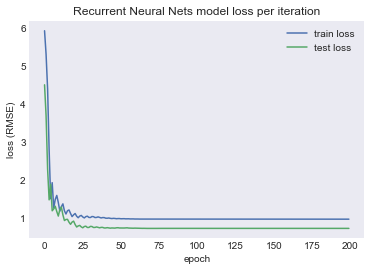

In [3451]:
# Plot loss per iteration

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.title('Recurrent Neural Nets model loss per iteration')
plt.xlabel('epoch')
plt.ylabel('loss (RMSE)')
plt.legend()
plt.show()

In [3452]:
# Make predictions and get RMSE

rnnPreds = []

# last train input
lastX = X_test[0].view(T)

while len(rnnPreds) < len(y_test):
    input_ = lastX.view(1, T, 1)
    pred = rnnModel(input_)

    rnnPreds.append(pred[0,0].item())

    # next input
    lastX = torch.cat((lastX[1:], pred[0]))

In [3453]:
y_test = np.array(y_test).reshape(1, -1)[0]
rnnRMSE = RMSE(y_test, rnnPreds)

In [3454]:
rnnRMSE

3.0083512454717454

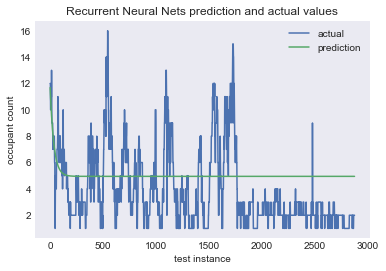

In [3455]:
# Plot actual and predicted values

plt.plot(y_test, label='actual')
plt.plot(rnnPreds, label='prediction')
plt.title('Recurrent Neural Nets prediction and actual values')
plt.ylabel('occupant count')
plt.xlabel('test instance')
plt.legend();

In [3456]:
# Get RNN model params

for _ in rnnModel.rnn.parameters():
    print(_)

Parameter containing:
tensor([[ 0.9194],
        [-0.2277],
        [ 0.4249],
        [-0.3714],
        [-0.6009]], requires_grad=True)
Parameter containing:
tensor([[-0.1843,  0.0819, -0.1114,  0.9942,  0.1622],
        [-0.3677,  0.0763, -0.2335,  0.1125,  0.2229],
        [ 0.2756,  0.2017,  0.4176,  0.3320,  0.3392],
        [-0.7259,  0.1788, -0.3653, -0.4653, -0.3939],
        [-0.5700,  0.1325, -1.0081, -0.4150, -0.6631]], requires_grad=True)
Parameter containing:
tensor([ 0.1960,  0.3518, -0.1551, -0.9538, -0.6351], requires_grad=True)
Parameter containing:
tensor([ 0.2176, -0.2857, -0.3849, -0.8217, -0.4359], requires_grad=True)


In [3457]:
W_xh, W_hh, b_xh, b_hh = rnnModel.rnn.parameters()

W_xh = W_xh.data.numpy()
W_hh = W_hh.data.numpy()
b_xh = b_xh.data.numpy()
b_hh = b_hh.data.numpy()

In [3458]:
W_xh.shape, b_xh.shape, W_hh.shape, b_hh.shape

((5, 1), (5,), (5, 5), (5,))

In [3459]:
Wo, bo = rnnModel.fc.parameters()

In [3460]:
Wo = Wo.data.numpy()
bo = bo.data.numpy()
Wo.shape, bo.shape     

((1, 5), (1,))

In [3481]:
# sanity check

# hidden = 0
# for _ in rnnModel.named_parameters():
#     if 'rnn.weight_ih' in _[0]:
#         hidden += _[1][0]*X_test[0]
#     elif 'rnn.weight_hh' in _[0]:
#         prev_hidden = rnnModel.get_hidden(X_train[-1].view(1, T, 1))
#         hidden = hidden + _[1][0]*prev_hidden
#     elif 'rnn.bias' in _[0]:
#         hidden += _[1][0]
#     elif 'fc.weight' in _[0]:
#         prediction = _[1][0]*hidden[:, -1, :]
#     else:
#         prediction += _[1][0]

h_last = np.zeros(5) 
x = X[threshold].reshape(T, -1) # X_test[0].data.numpy()
Yhats = np.zeros((T, 1))

for t in range(T):
    h = x[t].dot(W_xh.T) + b_xh + h_last.dot(W_hh.T) + b_hh
    h = np.array([_ if _ > 0 else 0 for _ in h]) # ReLU 
    y = h.dot(Wo.T) + bo  # we only care about this value on last iteration
    Yhats[t] = y
    h_last = h
    
print(Yhats) 

[[ 7.4111107 ]
 [ 7.32631089]
 [ 8.52708425]
 [ 7.91191162]
 [ 7.92273531]
 [10.27465969]
 [10.52750674]
 [11.48793181]
 [10.83229757]
 [12.40779987]
 [10.96222246]
 [11.68805247]]


In [3482]:
# Get model output 

inputs = torch.from_numpy(X[threshold:].astype(np.float32))
out = rnnModel(inputs)
out

tensor([[11.6881],
        [11.6917],
        [11.7261],
        ...,
        [ 2.1085],
        [ 2.1088],
        [ 2.1089]], grad_fn=<AddmmBackward0>)

In [3483]:
Yhats_torch = out.detach().numpy()

In [3489]:
# Check

np.allclose(Yhats[-1], Yhats_torch[0][0])

True

--> Our calculation of the prediction for the first test instance indeed
 matches the model's output 
 - Yhats[-1] == Yhats_torch[0][0]